# Описание задачи

Руководство компании обратило внимание на то, что сотрудники старше 35 лет болеют чаще, чем более молодые сотрудники. Кроме этого, среди мужчин количество пропусков рабочих дней в связи с больничным выше, чем среди женщин. В связи с этой ситуацией, руководство организации планирует ввести дополнительные медицинские осмотры среди групп риска.

Вам необходимо проверить следующие гипотезы:
   1) Мужчины пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще женщин.
   2) Работники старше 35 лет (age) пропускают в течение года более 2 рабочих дней (work_days) по болезни значимо чаще своих более молодых коллег.

Все необходимые данные содержатся в файле «Статистика».
Решение необходимо предоставить:

1) В виде jupyter notebook (с аккуратно оформленным кодом, графиками и описанной логикой решения).
2) В виде дашборда на Streamlit с простым функционалом:
    a) должна быть возможность загрузить csv, в формате аналогично файлу «Статистика»
    b) должна быть возможность задать параметры age и work_days
    c) указан результат проверки гипотез
    d) указана логика получения результата (должны быть отрисованы графики распределений, указаны критерии проверки (стат. тесты, статистики, уровень значимости т.п.)

# Загрузка необходимых библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, t, chi2_contingency

# Загрузка данных и построение графиков

In [2]:
data = pd.read_csv('Статистика')

In [3]:
data.head()

,Количество больничных дней,Возраст,Пол
0,5,39,Ж
1,4,54,М
2,4,26,М
3,5,42,М
4,4,29,М


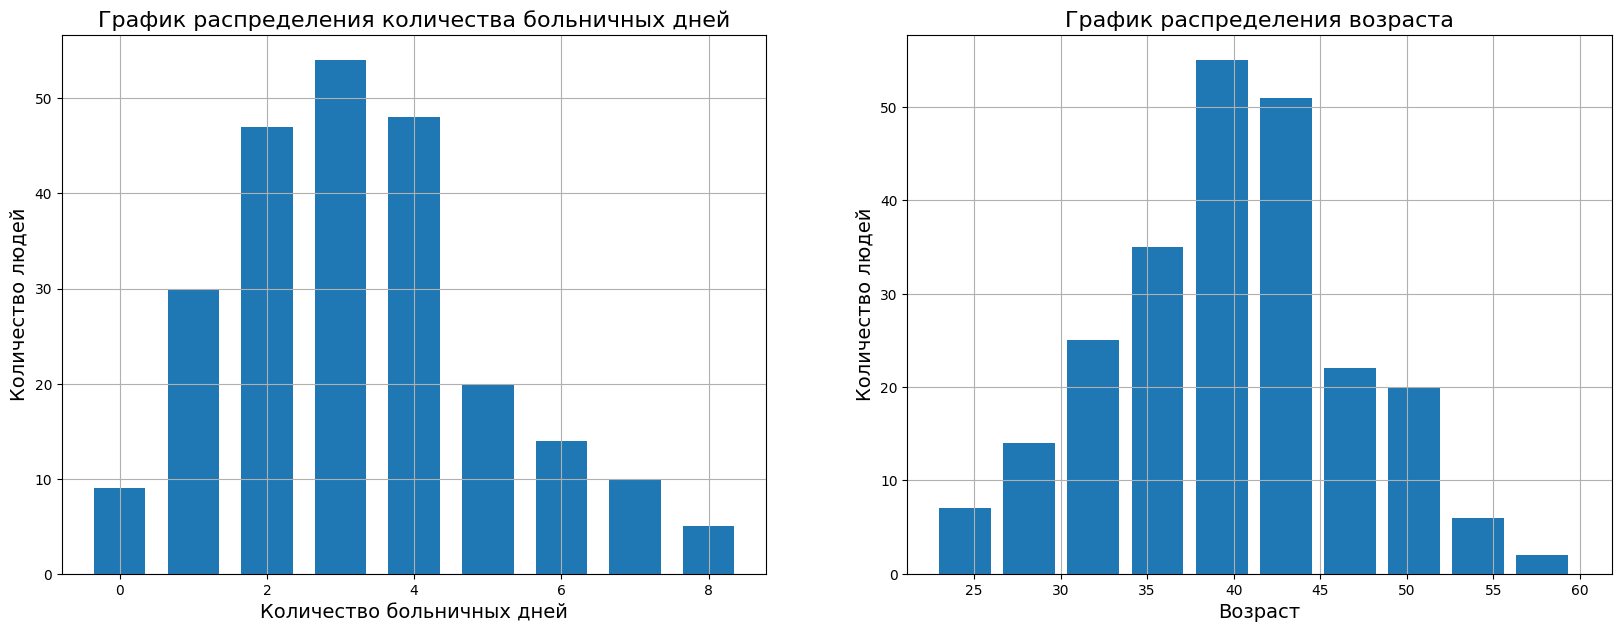

In [4]:
plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)

width = 0.7
index, count = np.unique(data['Количество больничных дней'], return_counts=True)

plt.title('График распределения количества больничных дней', fontsize=16)
plt.bar(index, count, width)
plt.xlabel('Количество больничных дней', fontsize=14)
plt.ylabel('Количество людей', fontsize=14)
plt.grid()

plt.subplot(1, 2, 2)
plt.title('График распределения возраста', fontsize=16)
plt.hist(data['Возраст'], bins=10, width=3)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Количество людей', fontsize=14)
plt.grid()

plt.show()

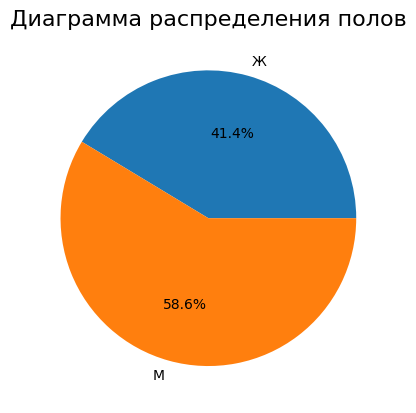

In [5]:
plt.title('Диаграмма распределения полов', fontsize=16)
label, count = np.unique(data['Пол'], return_counts=True)
plt.pie(count, labels=label, autopct='%1.1f%%')
plt.show()

# Проверка гипотез

## Описание процесса

Для каждой из гипотезы мы строим таблицу сопряженности и применяем к ней критерий Хи квадрат для проверки на независимость. Если выборки оказываются независимы, то мы применяем U-критерий Манна-Уитни, если же выборки зависимы, то применяем t-критерий (этот критерий можно применять, так как при больших выборках выборочные средние подчиняются нормальному закону, даже если исходная переменная не является нормальной или измерена с погрешностью.).

## Реализация

In [6]:
def men_women(data, work_days=2, alpha=0.05, print_flag=False):
    women = data.loc[data['Пол'] == 'Ж']['Количество больничных дней']
    men = data.loc[data['Пол'] == 'М']['Количество больничных дней']
    table = pd.DataFrame([[len(women[women <= work_days]), len(women[women > work_days])],
                          [len(men[men <= work_days]), len(men[men > work_days])]],
                         columns=[f'<{work_days}', f'>{work_days}'], index=['Ж', 'М'])
    if print_flag:
        print('Сравнение мужчин и женщин')
        print('Матрица сопряженности')
        print(table)
    chi2_statistic, p_value, dof, exp = chi2_contingency(table, correction = False)
    if p_value > alpha:
        #Ваборки зависимы
        if print_flag: print('Ваборки зависимы')
        m1 = np.mean(men[men > work_days])
        m2 = np.mean(women[women > work_days])
        s1 = np.std(men[men > work_days]) ** 2
        s2 = np.std(women[women > work_days]) ** 2
        n1 = len(men[men > work_days])
        n2 = len(women[women > work_days])

        statistic = (m1 - m2)/(np.sqrt(s1/n1 + s2/ n2))
        degrees = round((s1/n1 + s2/n2) ** 2 / (((s1/n1) ** 2 / (n1 - 1)) + (s2 / n2) ** 2 / (n2 - 1)))
        pval = t.sf(statistic, degrees-1) # t > tt
    else:
        #Выборки независимы
        if print_flag: print('Выборки независимы')
        statistic, pval = mannwhitneyu(men, women, alternative='greater')
    if print_flag:
        print('Statistic =', statistic)
        print('P-value =', pval)
        print()
    return statistic, pval

In [7]:
def old_young(data, age=35, work_days=2, alpha=0.05, print_flag=False):
    old = data.loc[data['Возраст'] > age]['Количество больничных дней']
    young = data.loc[data['Возраст'] <= age]['Количество больничных дней']
    table = pd.DataFrame([[len(old[old <= work_days]), len(old[old > work_days])],
                          [len(young[young <= work_days]), len(young[young > work_days])]],
                         columns=[f'<{work_days}', f'>{work_days}'], index=[f'старше {age}', f'младше {age}'])
    if print_flag:
        print(f'Сравнение людей старше и младше {age} лет')
        print('Матрица сопряженности')
        print(table)
    chi2_statistic, p_value, dof, exp = chi2_contingency(table, correction = False)
    if p_value > alpha:
        #Ваборки зависимы
        if print_flag: print('Ваборки зависимы')
        m1 = np.mean(old[old > work_days])
        m2 = np.mean(young[young > work_days])
        s1 = np.std(old[old > work_days]) ** 2
        s2 = np.std(young[young > work_days]) ** 2
        n1 = len(old[old > work_days])
        n2 = len(young[young > work_days])

        statistic = (m1 - m2)/(np.sqrt(s1/n1 + s2/ n2))
        degrees = round((s1/n1 + s2/n2) ** 2 / (((s1/n1) ** 2 / (n1 - 1)) + (s2 / n2) ** 2 / (n2 - 1)))
        pval = t.sf(statistic, degrees-1) # t > tt
    else:
        #Выборки независимы
        if print_flag: print('Выборки независимы')
        statistic, pval = mannwhitneyu(old, young, alternative='greater')
    if print_flag:
        print('Statistic =', statistic)
        print('P-value =', pval)
        print()

    return statistic, pval

In [8]:
def f(data, age=35, work_days=2, alpha=0.05, print_flag=False):
    one_stat, one_p_value = men_women(data, work_days, alpha, print_flag)
    two_stat, two_p_value = old_young(data, age, work_days, alpha, print_flag)
    if one_p_value > alpha:
        print(f'Гипотеза о том, что мужчины пропускают в течение года более {work_days} рабочих дней по болезни значимо чаще женщин, отвергается.')
    else:
         print(f'Гипотеза о том, что мужчины пропускают в течение года более {work_days} рабочих дней по болезни значимо чаще женщин, не отвергается.')
    print()
    if two_p_value > alpha:
        print(f'Работники старше {age} лет пропускают в течение года более {work_days} рабочих дней по болезни значимо чаще своих более молодых коллег, отвергается.')
    else:
         print(f'Работники старше {age} лет пропускают в течение года более {work_days} рабочих дней по болезни значимо чаще своих более молодых коллег, не отвергается.')
    return  one_stat, one_p_value, two_stat, two_p_value

In [9]:
age = 35
work_days = 2
alpha = 0.05
print_flag = True
f(data, age, work_days, alpha, print_flag)
None

Сравнение мужчин и женщин
Матрица сопряженности
   <2  >2
Ж  31  67
М  55  84
Ваборки зависимы
Statistic = 0.4259118915343131
P-value = 0.3353975024589727

Сравнение людей старше и младше 35 лет
Матрица сопряженности
           <2   >2
старше 35  65  115
младше 35  21   36
Ваборки зависимы
Statistic = -0.7400020400614724
P-value = 0.7687770295647545

Гипотеза о том, что мужчины пропускают в течение года более 2 рабочих дней по болезни значимо чаще женщин, отвергается.

Работники старше 35 лет пропускают в течение года более 2 рабочих дней по болезни значимо чаще своих более молодых коллег, отвергается.
